In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error

## Define functions

In [3]:
def estimate_pred_upper_limit(prot,n_samples):
    """
    Resample abundance scores for the given protein n_samples 
    times from normal distributions with mean equal to the experimental 
    abundance score and standard deviation equal to the experimental score
    standard deviation.
    Return the average Pearson's r, Spearman's r and MAE calculated between 
    experimental scores and the n_samples resampled data sets. 
    """
    # load experimental data
    vampseq_df = pd.read_csv("../data/vampseq_data/processed/vampseq_soluble_df.csv")
    vampseq_df_group = vampseq_df.groupby("prot").get_group(prot).dropna(subset=["abundance_score","abundance_score_sd"])

    # get arrays with exp abundance scores and score standard deviations
    exp_abundance = np.array(vampseq_df_group['abundance_score'])
    exp_abundance_sd = np.array(vampseq_df_group['abundance_score_sd'])

    # resample abundance scores based on standard deviations
    resampled_data = np.array([np.random.normal(
        loc=exp_abundance, scale=exp_abundance_sd, size=None) for i in range(n_samples)])

    # calculate correlations coefficients and MAE between experimental score and resampled scores
    pearson_list = [pearsonr(exp_abundance,resampled_data[i])[0] for i in range(n_samples)]
    spearman_list = [spearmanr(exp_abundance,resampled_data[i])[0] for i in range(n_samples)]
    mae_list = [mean_absolute_error(exp_abundance,resampled_data[i]) for i in range(n_samples)]

    # calculate means and standard deviations of resampling results
    pearson_result = (np.mean(pearson_list), np.std(pearson_list,ddof=1))
    spearman_result = (np.mean(spearman_list), np.std(spearman_list,ddof=1))
    mae_result = (np.mean(mae_list), np.std(mae_list,ddof=1))
    
    return pearson_result, spearman_result, mae_result

## Load data

In [4]:
# load vampseq data for all variants in soluble regions of the proteins
vampseq_df = pd.read_csv("../data/vampseq_data/processed/vampseq_soluble_df.csv")
vampseq_df = vampseq_df.dropna(subset=["abundance_score"])

In [5]:
# load protein sequences
sequence_dict = pd.read_pickle("../data/sequences.pkl")

In [6]:
# load dataframe with protein structure features
struc_feat_df = pd.read_csv("../output/structure_features/structure_features_AF.csv")

In [7]:
# define proteins
proteins = ['PTEN','TPMT','CYP2C9','NUDT15','ASPA','PRKN']

## Run calculations

In [8]:
# print total number of variants

print(len(vampseq_df.dropna(subset=["abundance_score"])))

31614


In [9]:
# calculate number of variants with measured abundance scores, mutational completeness, 
# sequence coverage and average mutational depth for each protein

variant_count_list = []
mutational_completeness_list = []
positional_coverage_list = []
avg_mutational_depth_list = []

for prot in proteins:

    print(prot)
    
    # get missense variant scores for prot
    vampseq_df_group = vampseq_df.groupby("prot").get_group(prot)

    # get sequence length
    if prot == "CYP2C9":
        sequence_length = len(sequence_dict[prot][28:])
    else:
        sequence_length = len(sequence_dict[prot])
    print("Sequence length:", sequence_length)

    # number of missense scores 
    number_of_missense_scores = len(vampseq_df_group)
    variant_count_list.append(number_of_missense_scores)
    print("Total number of variants with abundance scores:",number_of_missense_scores)

    # overall mutational completeness
    mutational_completeness = (number_of_missense_scores / (19 * sequence_length)) * 100
    mutational_completeness_list.append(mutational_completeness)
    print("Overall mutational completeness:",mutational_completeness)

    # number of unique positions with at least one abundance score
    number_of_positions_with_scores = len(np.unique(vampseq_df_group.resi.values))
    print("Number of unique positions with at least one abundance score:",number_of_positions_with_scores)
          
    # positional coverage (only a single score per residue required)
    positional_coverage = number_of_positions_with_scores / sequence_length
    positional_coverage_list.append(positional_coverage)
    print("Positional coverage:",positional_coverage)
    
    # create array which for each position along the sequence contains the number
    # of variants with measured abundance scores for that position 
    score_count_per_position_arr = vampseq_df_group.groupby("resi").count().variant.values

    # mutational depth (average number of scores per residue/sequence position)
    score_count_per_position_mean = np.mean(score_count_per_position_arr)
    avg_mutational_depth_list.append(score_count_per_position_mean)
    print("Average number of scores per residue/sequence position:",score_count_per_position_mean)
    
    # minimum number of scores per residue/sequence position
    score_count_per_position_min = np.min(score_count_per_position_arr)
    print("Min number of scores per residue/sequence position:",score_count_per_position_min)
    
    # max number of scores per residue/sequence position
    score_count_per_position_max = np.max(score_count_per_position_arr)
    print("Max number of scores per residue/sequence position:",score_count_per_position_max,'\n')

PTEN
Sequence length: 403
Total number of variants with abundance scores: 4387
Overall mutational completeness: 57.29397936528666
Number of unique positions with at least one abundance score: 379
Positional coverage: 0.9404466501240695
Average number of scores per residue/sequence position: 11.575197889182059
Min number of scores per residue/sequence position: 1
Max number of scores per residue/sequence position: 19 

TPMT
Sequence length: 245
Total number of variants with abundance scores: 3689
Overall mutational completeness: 79.24812030075188
Number of unique positions with at least one abundance score: 241
Positional coverage: 0.9836734693877551
Average number of scores per residue/sequence position: 15.307053941908714
Min number of scores per residue/sequence position: 4
Max number of scores per residue/sequence position: 19 

CYP2C9
Sequence length: 462
Total number of variants with abundance scores: 6017
Overall mutational completeness: 68.54636591478696
Number of unique positio

In [10]:
# resample datasets to quantify noise levels and estimate prediction upper limits

pearson_mean_list = []
spearman_mean_list = []
mae_mean_list = []

n_samples = 100

for prot in proteins:
    pearson_mean, spearman_mean, mae_mean = estimate_pred_upper_limit(prot,n_samples)
    pearson_mean_list.append(pearson_mean[0])
    spearman_mean_list.append(spearman_mean[0])
    mae_mean_list.append(mae_mean[0])

In [11]:
# count number of residues sitting in different structural contexts

# define groups of helix, strand and loop
helix_types = ["H","G","I"]
strand_types = ["E","B"]
loop_types = ["T","S","-"]

secondary_struc_dict = {}
exposure_dict = {}

for prot in proteins:

    # group by protien
    struc_feat_prot_df = struc_feat_df.groupby("prot").get_group(prot)
    struc_feat_prot_df = struc_feat_prot_df.dropna(subset="secondary_structure")
    
    # make array with secondary structure assigned by dssp
    secondary_structure_arr = struc_feat_prot_df["secondary_structure"].values

    # find secondary structure types in secondary_structure_arr
    helix_arr = np.isin(secondary_structure_arr, helix_types)
    strand_arr = np.isin(secondary_structure_arr, strand_types)
    loop_arr = np.isin(secondary_structure_arr, loop_types)

    # define sequence length
    seq_len = len(secondary_structure_arr)

    # calc fraction of secondary structure
    helix_resi = np.sum(helix_arr) / seq_len
    strand_resi = np.sum(strand_arr) / seq_len
    loop_resi = np.sum(loop_arr) / seq_len

    # add to dict
    secondary_struc_dict[prot] = [helix_resi, strand_resi, loop_resi]
    
    # calc percentage of buried and exposed
    buried_resi = np.sum(struc_feat_prot_df['rASA'].values <= 0.1) / seq_len
    exposed_resi = np.sum(struc_feat_prot_df['rASA'].values > 0.1) / seq_len
    
    # add to dict
    exposure_dict[prot] = [buried_resi, exposed_resi]
    
# make dataframes from dicts    
secondary_struc_df = pd.DataFrame.from_dict(secondary_struc_dict, orient='index', columns=["Helix","Strand ","Loop"])
exposure_df = pd.DataFrame.from_dict(exposure_dict, orient='index', columns=["Buried","Exposed"])

In [12]:
# count number of different amino acid types in each protein

aa_list_ordered = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

aa_freq_dict = {}

for prot in proteins:
    
    if prot == "CYP2C9":
        sequence = sequence_dict[prot][28:]
        seq_len = len(sequence)
    else:
        sequence = sequence_dict[prot]
        seq_len = len(sequence)
    
    aa_list, aa_count_list = np.unique(list(sequence), return_counts=True)
    
    assert np.all(aa_list == aa_list_ordered)
    
    aa_freq_list = np.array(aa_count_list) / seq_len
    aa_freq_dict[prot] = aa_freq_list
    
aa_freq_df = pd.DataFrame.from_dict(aa_freq_dict, orient='index', columns = aa_list_ordered)

## Plot

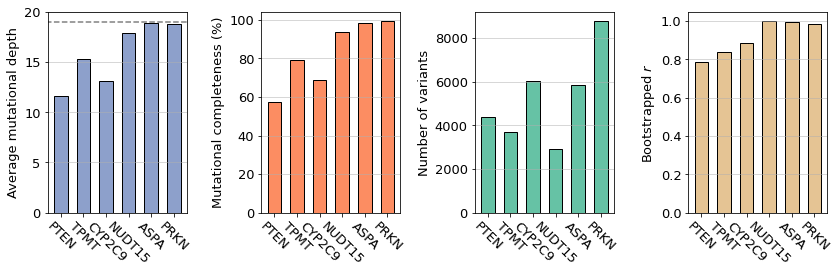

In [13]:
# plot mutational depth, mutational completeness, number of variants and bootstrapped r 

plt.rcParams['font.size'] = '13'
Set2_colors = sns.color_palette("Set2")
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 4, 1)
plt.bar(proteins,avg_mutational_depth_list,width=0.6, color = Set2_colors[2], edgecolor="black")
plt.grid(visible=True,axis="y",linewidth = "0.5")
plt.hlines(y = 19, xmin=-1, xmax=6, color="black", ls="dashed", alpha=0.5)
plt.xticks(rotation=-45)
plt.ylabel("Average mutational depth")
plt.xlim(-0.58, 5.58)
plt.ylim(0,20)

plt.subplot(1, 4, 2)
plt.bar(proteins,mutational_completeness_list,width=0.6, color = Set2_colors[1], edgecolor="black")
plt.grid(visible=True,axis="y",linewidth = "0.5")
plt.xticks(rotation=-45)
plt.ylabel("Mutational completeness (%)")
plt.xlim(-0.58, 5.58)

plt.subplot(1, 4, 3)
plt.bar(proteins,variant_count_list,width=0.6, color = Set2_colors[0], edgecolor="black")
plt.grid(visible=True,axis="y",linewidth = "0.5")
plt.xticks(rotation=-45)
plt.ylabel("Number of variants")

plt.subplot(1, 4, 4)
plt.bar(proteins,pearson_mean_list,width=0.6, color = Set2_colors[6], edgecolor="black")
plt.grid(visible=True,axis="y",linewidth = "0.5")
plt.xticks(rotation=-45)
plt.ylabel("Bootstrapped $r$")

plt.tight_layout()

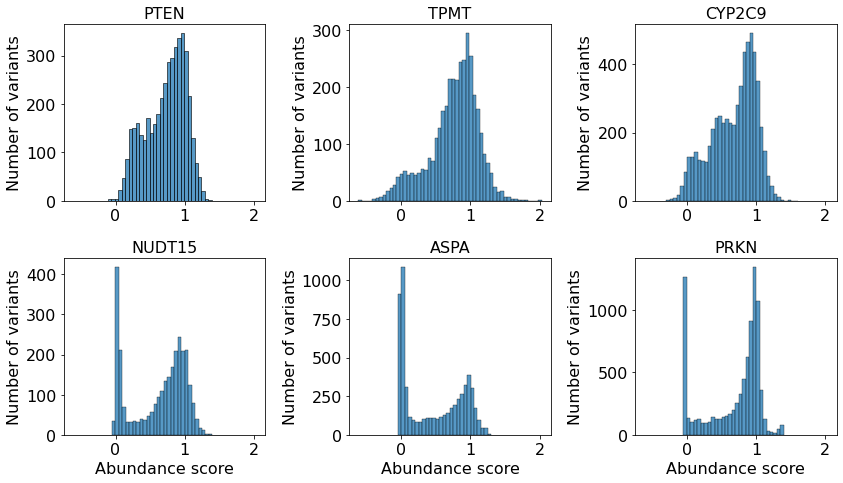

In [14]:
# plot abundance score distribitions
    
plt.rcParams['font.size'] = '16'
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(12,7))

for i in range(len(proteins)):
    
    vampseq_df_group = vampseq_df.groupby("prot").get_group(proteins[i])
    abundance_score_arr = vampseq_df_group.abundance_score.values
    
    ax = sns.histplot(abundance_score_arr, binwidth=0.05, ax=axes.flatten()[i], kde=False)
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.set_xlabel('Abundance score') 
    ax.set_ylabel('Number of variants') 
    ax.set_title(proteins[i], fontsize=16) 

plt.tight_layout()
plt.show()

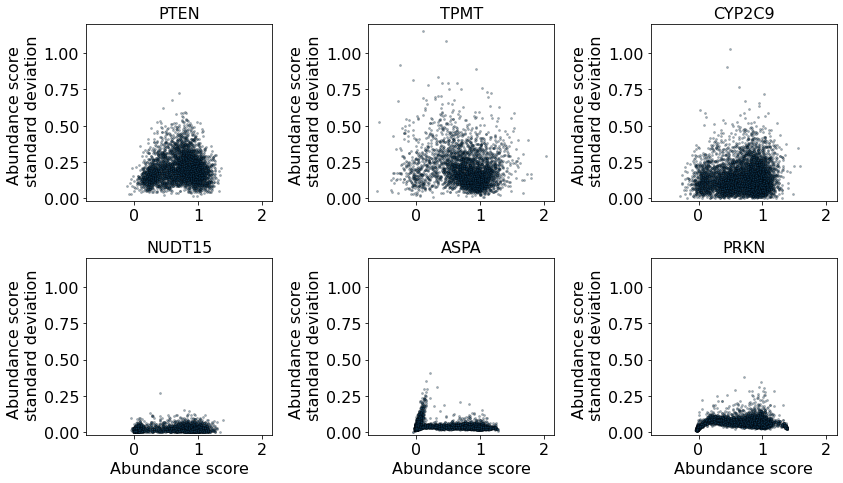

In [15]:
# plot abundance score standard deviations
    
plt.rcParams['font.size'] = '16'
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(12,7))

for i in range(len(proteins)):
    
    vampseq_df_group = vampseq_df.groupby("prot").get_group(proteins[i])
    abundance_score_arr = vampseq_df_group.abundance_score.values
    abundance_score_sd_arr = vampseq_df_group.abundance_score_sd.values
    
    ax = plt.subplot(2, 3, i+1)  
    plt.scatter(abundance_score_arr,abundance_score_sd_arr,s=3,edgecolor="black",alpha=0.3)
    ax.xaxis.set_tick_params(labelbottom=True)
    if i in [3,4,5]:
        plt.xlabel('Abundance score')
    plt.ylabel('Abundance score \n standard deviation')
    plt.title(proteins[i], fontsize=16)
    plt.ylim(-0.02,1.2)

plt.tight_layout()
plt.show()

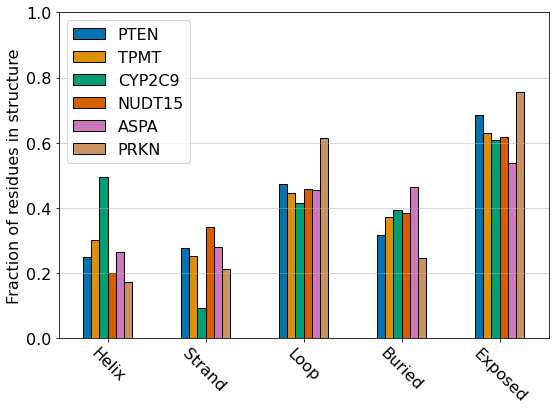

In [16]:
# plot structure composition overview

plt.rcParams['font.size'] = '16'
colors = sns.color_palette("colorblind")

secondary_struc_df.join(exposure_df).T.plot(kind="bar",legend=True, figsize=(8,6), color=colors, edgecolor="black")
plt.grid(visible=True,axis="y",linewidth = "0.5")
plt.ylim(0,1)
plt.ylabel("Fraction of residues in structure")
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

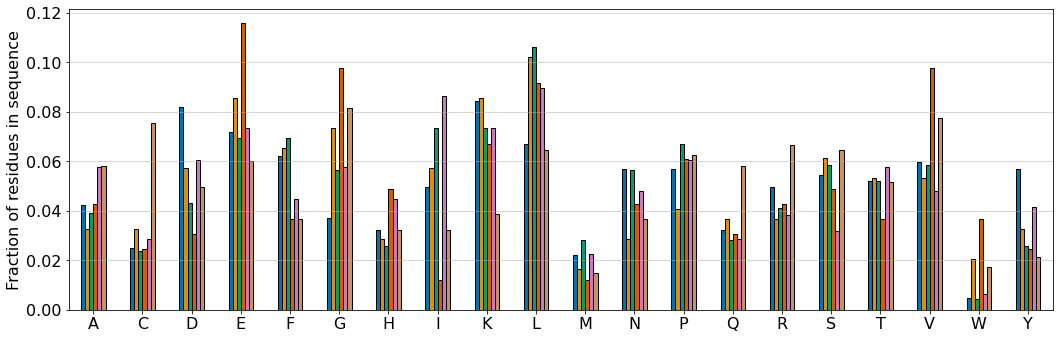

In [17]:
# plot sequence composition overview

plt.rcParams['font.size'] = '16'
Set2_colors = sns.color_palette("colorblind")

aa_freq_df.T.plot(kind="bar",legend=False, figsize=(15,5), color=Set2_colors, edgecolor="black")
plt.grid(visible=True,axis="y",linewidth = "0.5")
plt.ylabel("Fraction of residues in sequence")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()